In [ ]:
import tensorflow as tf

shakespeare_url = 'https://homl.info/shakespeare'
filepath = tf.keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
  shakespeare_txt = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(shakespeare_txt[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [ ]:
''.join(sorted(set(shakespeare_txt.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(split = 'character',
                                                   standardize='lower')
text_vec_layer.adapt([shakespeare_txt])
encoded = text_vec_layer([shakespeare_txt])[0]

In [ ]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 np.str_(' '),
 np.str_('e'),
 np.str_('t'),
 np.str_('o'),
 np.str_('a'),
 np.str_('i'),
 np.str_('h'),
 np.str_('s'),
 np.str_('r'),
 np.str_('n'),
 np.str_('\n'),
 np.str_('l'),
 np.str_('d'),
 np.str_('u'),
 np.str_('m'),
 np.str_('y'),
 np.str_('w'),
 np.str_(','),
 np.str_('c'),
 np.str_('f'),
 np.str_('g'),
 np.str_('b'),
 np.str_('p'),
 np.str_(':'),
 np.str_('k'),
 np.str_('v'),
 np.str_('.'),
 np.str_("'"),
 np.str_(';'),
 np.str_('?'),
 np.str_('!'),
 np.str_('-'),
 np.str_('j'),
 np.str_('q'),
 np.str_('x'),
 np.str_('z'),
 np.str_('3'),
 np.str_('&'),
 np.str_('$')]

In [ ]:
encoded -= 2                                                # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2
dataset_size = len(encoded)
dataset_size

1115394

In [ ]:
n_tokens

39

In [ ]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length +  1, shift = 1, drop_remainder=True)
  ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
  if shuffle:
    ds = ds.shuffle(100_000, seed=seed)
  ds = ds.batch(batch_size)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [ ]:
list(to_dataset(tf.range(10), 3))

[(<tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8],
         [7, 8, 9]], dtype=int32)>)]

In [ ]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

#Building and Training the Char-RNN Model

In [ ]:

tf.random.set_seed(42)                     # extra code - ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'my_shakespeare_model.keras', monitor='val_accuracy', save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=3,
                    callbacks=[model_ckpt])

Epoch 1/3
  31242/Unknown 411s 12ms/step - accuracy: 0.5471 - loss: 1.4998

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31247/31247 ━━━━━━━━━━━━━━━━━━━━ 427s 13ms/step - accuracy: 0.5471 - loss: 1.4998 - val_accuracy: 0.5360 - val_loss: 1.5956
Epoch 2/3
31247/31247 ━━━━━━━━━━━━━━━━━━━━ 390s 12ms/step - accuracy: 0.5973 - loss: 1.2925 - val_accuracy: 0.5402 - val_loss: 1.5846
Epoch 3/3
31247/31247 ━━━━━━━━━━━━━━━━━━━━ 443s 14ms/step - accuracy: 0.6017 - loss: 1.2726 - val_accuracy: 0.5453 - val_loss: 1.5645


In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X-2),  # no <PAD> or <UNK> tokens
    model
])

In [ ]:
# text = 'To be or not to b'
# vec = text_vec_layer(text)
# embedding = tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16)
# emb = embedding(vec)

In [ ]:
# y_proba = model.predict(emb)[0, -1]
# y_pred = tf.argmax(y_proba)   #3 choose the most probable character ID
# text_vec_layer.get_vocabulary()[y_pred+2] # vocabulary has padding and unknown so we need to add 2

In [ ]:
# # extra code – downloads a pretrained model
# from pathlib import Path
# url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
# path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
# model_path = Path(path).with_name("shakespeare_model")
# shakespeare_model = tf.keras.models.load_model(model_path)

In [ ]:
# y_proba = shakespeare_model.predict(['To be or to b'])[0, -1]
# y_pred = tf.argmax(y_proba)     # choose the most probable character ID
# text_vec_layer.get_vocabulary()[y_pred+2]     # vocabulary has padding and unknown so we need to add 2

In [ ]:
# shakespeare_model.predict(['To be or not to b'])[0, -1]

#Generating Fake Shakespeare Text

In [ ]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])   # probas = 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [ ]:
def to_dataset_for_stateful_rnn(sequence, length):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1, shift = length, drop_remainder= True)
  ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1000_000:1060_000], length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1060_000:], length)

In [ ]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [ ]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [ ]:
norm_logs = log_probas / 1

In [ ]:
for i in range(100):
  print(tf.random.categorical(norm_logs, num_samples =1))

tf.Tensor([[2]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[2]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[1]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), dtype=int64)
tf.Tensor([[2]], shape=(1, 1), dtype=int64)
tf.Tensor([[0]], shape=(1, 1), d

In [ ]:
def next_char(text, temperature=1):
  y_proba = shakespeare_model.predict([text])[0, 1:]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
  return text_vac_layer.get_vocabulary()[char_id + 2]

In [ ]:
def extend_text(text, n_chars=100, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [ ]:
tf.random.set_seed(42)

In [ ]:
# print(extend_text('''Now we are even to the death''', temperature=0.01))

In [ ]:
# print(extend_text('''to be or not to be''', temperature=1))

In [ ]:
# print(extend_text('''to be or not to be''', temperature=1))

#Stateful RNN

In [ ]:

def to_dataset_for_stateful_rnn(sequence, length):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1 , shift = length, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [ ]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [ ]:
# extra code - shows one way to prepare a batched for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))


def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

#Sentiment Analysis

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
ttest_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2TIOR_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2TIOR_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.Y2TIOR_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for review, label in raw_train_set.take(4):
  print(review.numpy()[:200], "...")
  print("label:", label.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting " ...
label: 0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ' ...
label: 0
b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun' ...
label: 0
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf' ...
label: 1


In [ ]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs = 2)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.4948 - loss: 0.6939 - val_accuracy: 0.5008 - val_loss: 0.6929
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5036 - loss: 0.6934 - val_accuracy: 0.5028 - val_loss: 0.6929


#Masking

In [ ]:
embed_size =128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs = 5)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.6277 - loss: 0.6385 - val_accuracy: 0.8428 - val_loss: 0.3730
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8508 - loss: 0.3454 - val_accuracy: 0.8576 - val_loss: 0.3205
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8814 - loss: 0.2903 - val_accuracy: 0.8776 - val_loss: 0.3031
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8907 - loss: 0.2640 - val_accuracy: 0.8644 - val_loss: 0.3431
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9045 - loss: 0.2433 - val_accuracy: 0.8596 - val_loss: 0.3281


In [ ]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=[], dtype = tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(token_ids)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout = 0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(Z)
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs = 5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(None,))
  warnings.warn(msg)


704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.6393 - loss: 0.6073 - val_accuracy: 0.8532 - val_loss: 0.3638
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8594 - loss: 0.3327 - val_accuracy: 0.8696 - val_loss: 0.3089
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.8838 - loss: 0.2865 - val_accuracy: 0.8708 - val_loss: 0.3136
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8875 - loss: 0.2678 - val_accuracy: 0.8688 - val_loss: 0.3178
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8958 - loss: 0.2544 - val_accuracy: 0.8708 - val_loss: 0.3218


In [ ]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens = vocab_size, ragged = True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [ ]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Lambda(lambda x: x.to_tensor()),
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs = 5)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.4916 - loss: 0.6938 - val_accuracy: 0.5028 - val_loss: 0.6930
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.4987 - loss: 0.6931 - val_accuracy: 0.5040 - val_loss: 0.6924
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5042 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5072 - loss: 0.6906 - val_accuracy: 0.5020 - val_loss: 0.6942
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5102 - loss: 0.6891 - val_accuracy: 0.5012 - val_loss: 0.6979


#Reusing Pretrained Embeddings and Language Models

In [ ]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                    trainable = True, dtype = tf.string, input_shape = [])(x)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              jit_compile=False,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data = valid_set, epochs = 10)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 75s 51ms/step - accuracy: 0.7995 - loss: 0.4655 - val_accuracy: 0.8556 - val_loss: 0.3310
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8634 - loss: 0.3248 - val_accuracy: 0.8436 - val_loss: 0.3289
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8617 - loss: 0.3244 - val_accuracy: 0.8516 - val_loss: 0.3229
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.8657 - loss: 0.3184 - val_accuracy: 0.8556 - val_loss: 0.3205
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8673 - loss: 0.3150 - val_accuracy: 0.8532 - val_loss: 0.3185
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8692 - loss: 0.3096 - val_accuracy: 0.8560 - val_loss: 0.3170
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8725 - loss: 0.3055 - val_accuracy: 0.8568 - val_loss: 0.3258
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8759 - loss: 0.2981 - 

#An-Encoder-Decoder Network for Neural Machine Translite

In [ ]:
from pathlib import Path

In [ ]:
from functools import cache
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                                      extract=True)
text = Path('/tmp/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt').read_text()

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [ ]:
for i in range(3):
  print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [ ]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [ ]:
text_vec_layer_en.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom'),
 np.str_('a'),
 np.str_('is'),
 np.str_('he')]

In [ ]:
text_vec_layer_es.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('startofseq'),
 np.str_('endofseq'),
 np.str_('de'),
 np.str_('que'),
 np.str_('a'),
 np.str_('no'),
 np.str_('tom'),
 np.str_('la')]

In [ ]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
y_train = tf.constant([f"{s} endofseq" for s in sentences_es[:100_000]])
y_valid = tf.constant([f"{s} endofseq" for s in sentences_es[100_000:]])

In [ ]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
decoder_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)

In [ ]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')
Y_proba = output_layer(decoder_outputs)

In [ ]:
# Explicitly create the Keras Model here
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])

In [ ]:
# Apply text_vec_layer_es to y_train and y_valid
y_train_encoded = text_vec_layer_es(y_train)
y_valid_encoded = text_vec_layer_es(y_valid)

# Update the model.fit call to use the encoded targets
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # You need to compile the model as well
model.fit((X_train, X_train_dec), y_train_encoded, epochs=10,
          validation_data=((X_valid, X_valid_dec), y_valid_encoded))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.0511 - loss: 3.5356 - val_accuracy: 0.0757 - val_loss: 2.0978
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 66s 21ms/step - accuracy: 0.0801 - loss: 1.9228 - val_accuracy: 0.0885 - val_loss: 1.5784
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 97s 26ms/step - accuracy: 0.0923 - loss: 1.4346 - val_accuracy: 0.0935 - val_loss: 1.3934
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.0995 - loss: 1.1779 - val_accuracy: 0.0951 - val_loss: 1.3358
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.1049 - loss: 0.9992 - val_accuracy: 0.0955 - val_loss: 1.3306
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 86s 27ms/step - accuracy: 0.1095 - loss: 0.8560 - val_accuracy: 0.0953 - val_loss: 1.3580
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 136s 25ms/step - accuracy: 0.1134 - loss: 0.7373 - val_accuracy: 0.0949 - val_loss: 1.4057
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.1168 

In [ ]:
def translate(sentence_en):
  translation = ''
  for word_idx in range(max_length):
    # Ensure inputs are batched tensors with shape (1,).
    # Convert the single string to a tensor and then add a batch dimension.
    X = tf.expand_dims(tf.constant(sentence_en, dtype=tf.string), axis=0)                 # encoder input
    X_dec = tf.expand_dims(tf.constant('startofseq ' + translation, dtype=tf.string), axis=0)       #decoder input

    y_proba = model.predict((X, X_dec))[0, word_idx]    # last token's probas
    predicted_word_id = np.argmax(y_proba)
    predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
    if predicted_word == 'endofseq':
      break
    translation += " " + predicted_word
  return translation.strip()

In [ ]:
translate("I like soccer")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


'me gusta el fútbol'

In [ ]:
translate("I like soccer and also going to the beach")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


'me gusta jugar y a mí también en el momento'

In [ ]:
translate("You are tom")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


'tú eres tom'

#Bidirectional RNNs

In [ ]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True)
)

In [ ]:
a = [1,2,3,4,5,6]
a[::2]
a[1::2]  #for demonstrative purpose

[2, 4, 6]

In [ ]:
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder (encoder_embeddings)

short_term_state = tf.keras.layers. Lambda (lambda states: tf.concat(states, axis = -1)) ([forward_h, backward_h])
long_term_state = tf.keras.layers.Lambda (lambda states: tf.concat(states, axis = -1)) ([forward_c, backward_c])

encoder_state = [short_term_state, long_term_state]

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences = True)
decoder_outputs = decoder(decoder_embeddings, initial_state = encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation = 'softmax')
Y_proba = output_layer(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

# Apply text_vec_layer_es to y_train and y_valid
y_train_encoded = text_vec_layer_es(y_train)
y_valid_encoded = text_vec_layer_es(y_valid)

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

# Update the model.fit call to use the encoded targets
model.fit((X_train, X_train_dec), y_train_encoded, epochs = 1,
          validation_data = ((X_valid, X_valid_dec), y_valid_encoded))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.0773 - loss: 2.2664 - val_accuracy: 0.0954 - val_loss: 1.3207


In [ ]:
translate("I like soccer")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'me gusta el fútbol'

In [ ]:
translate("I like sorcerer")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'me gusta la [UNK]'

#Beam Search

In [ ]:
def beam_search(sentence_en, beam_width, verbose=False):
  X = tf.constant([sentence_en], dtype = tf.string)    # encoder input
  X_dec = tf.constant(['startofseq'], dtype= tf.string)    # decoder input
  y_proba = model.predict((X, X_dec))[0, 0]   # first token's probas
  top_k = tf.math.top_k(y_proba, k = beam_width)
  top_translations = [#list of best (log proba, translation)
      (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
       for word_proba, word_id in zip(top_k.values, top_k.indices)
  ]

  if verbose:
    print("Top first words: ", top_translations)

  for idx in range(1, max_length):
    candidates = []
    for log_proba, translation in top_translations:
      if translation.endswith('endofseq'):
        candidates.append((log_proba, translation))
        continue    # translation is finished, so don't try to extend it
      X = tf.constant([sentence_en], dtype = tf.string)     # encoder input
      X_dec = tf.constant(['startofseq' + translation], dtype= tf.string)    # decoder input
      y_proba = model.predict((X, X_dec))[0, idx]
      for word_id, word_proba in enumerate(y_proba):
        word = text_vec_layer_es.get_vocabulary()[word_id]
        candidates.append((log_proba + np.log(word_proba),
                          f'{translation} {word}'))
  top_translations = sorted(candidates, reverse = True)[:beam_width]

  if verbose:
    print('Top translations so far:', top_translations)

  if all([tr.endswith('endofseq') for _, tr in top_translations]):
    return top_translations[0][1].replace('endofseq', '').strip()

In [ ]:
sentence_en = "I like cats and dogs"
translate(sentence_en)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'me gustan los perros como los gatos'

In [ ]:
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Top first words:  [(np.float32(-0.09060515), np.str_('me')), (np.float32(-4.1652565), np.str_('a')), (np.float32(-4.6853013), np.str_('yo'))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━

#Attention Is All You Need: The Transformer Architecture

In [ ]:
encoder_embeddings.shape

(None, 50, 128)

In [ ]:
max_length = 50
max_length = 50
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = encoder_embeddings.shape[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = decoder_embeddings.shape[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))
batch_max_len_dec = decoder_embeddings.shape[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, max_length, embed_size, dtype = tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    assert embed_size % 2 == 0, "embed_size must be even"
    p, i = np.meshgrid(np.arange(max_length),
                       2 * np.arange(embed_size // 2))
    pos_emb = np.empty((1, max_length, embed_size))
    pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
    self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
    self.supports_masking = True

  def call(self, inputs):
    batch_max_length = tf.shape(inputs)[1]
    return inputs + self.pos_encodings[:, :batch_max_length]

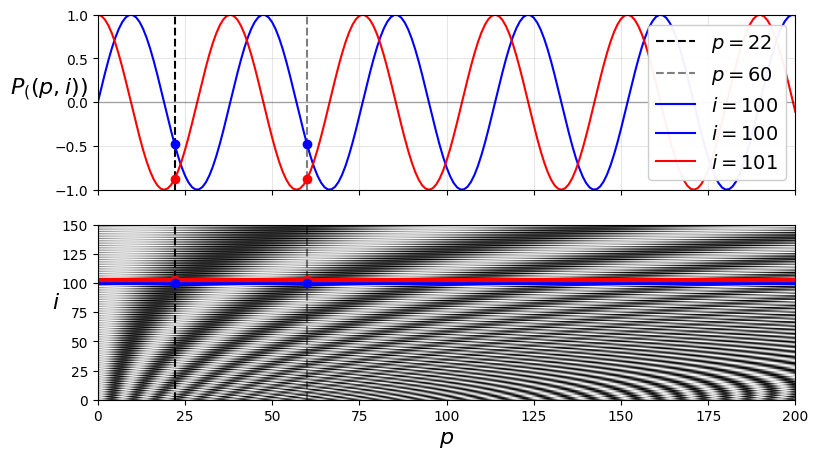

In [ ]:
import matplotlib.pyplot as plt
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:, i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:, i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize = 14, framealpha=0.95)
ax1.set_ylabel("$P_((p,i))$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2# need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

#Multi-head Attention

In [ ]:
N = 2 #instead of
num_heads = 8
dropout_rate = 0.1
n_units = 128
encoder_pad_mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(encoder_input_ids)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation='relu')(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.Dropout(dropout_rate)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add() ([Z, skip]))

In [ ]:
encoder_pad_mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(decoder_input_ids)[:, tf.newaxis]
decoder_pad_mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(decoder_input_ids)[:, tf.newaxis]

casual_mask = tf.linalg.band_part(
    tf.ones((batch_max_len_dec, batch_max_len_dec),dtype = tf.bool), -1, 0 )

In [ ]:
encoder_outputs = Z
Z = decoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads = num_heads, key_dim = embed_size, dropout = dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask = casual_mask & decoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = attn_layer(Z, value = encoder_outputs, attention_mask = encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  Z = tf.keras.layers.Dense(n_units, activation='relu')(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation = 'softmax')(Z)
model = tf.keras.Model(inputs = [encoder_inputs, decoder_inputs],
                       outputs = [Y_proba])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam',
              metrics = ['accuracy'])

In [ ]:
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data = ((X_valid, X_valid_dec), Y_valid))

NameError: name 'Y_train' is not defined

# Hugging Face

In [ ]:
import sys

In [ ]:
if 'google.colab' in sys.modules:
  %pip install -q -U transformmers
  %pip install -q -U datasets

ERROR: Could not find a version that satisfies the requirement transformmers (from versions: none)
ERROR: No matching distribution found for transformmers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrt

In [ ]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')
results = classifier('The actors were very convincing')
results

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9998143315315247}]

In [ ]:
classifier(['I am from India.', 'I am from Iraq.'])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [ ]:
model_name = 'huggingface/distilbert-base-uncased-finetuned-mnli'
classifier_mnli = pipeline('text-classification', model = model_name)
classifier_mnli('She loves me. [SEP] She loves me not')

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'contradiction', 'score': 0.6888499855995178}]

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
token_ids = tokenizer(['I like soccer.', 'We all love soccer!',
                       'Joe lived for a very li=ong time. [SEP] Joe is old'],
                      padding = True, return_tensors = 'tf')
token_ids

{'input_ids': <tf.Tensor: shape=(3, 17), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 101, 2057, 2035, 2293, 4715,  999,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 5622, 1027, 2006, 2290, 2051,
        1012,  102, 3533, 2003, 2214,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3, 17), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
token_ids = tokenizer([('I like soccer.', 'We all love soccer!'),
                       ('Joe lived for a very li=ong time. [SEP] Joe is old')],
                      padding = True, return_tensors = 'tf')
token_ids

{'input_ids': <tf.Tensor: shape=(2, 17), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 5622, 1027, 2006, 2290, 2051,
        1012,  102, 3533, 2003, 2214,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 17), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123815 ,  1.1786788 ,  1.4101003 ],
       [ 0.42024946,  0.08578102, -0.4495487 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
sentences = [('Sky is blue', 'Sky is red'), ('I love her', 'She loves me')]
X_train = tokenizer(sentences, padding=True, return_tensors='tf').data
y_train = tf.constant([0, 2]) # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 39s 39s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 82ms/step - loss: nan - accuracy: 0.5000
